In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from copy import copy

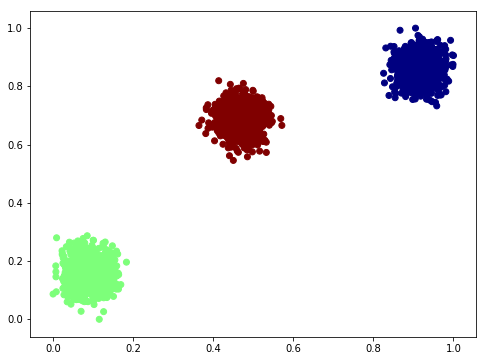

In [105]:
d = 2
k = 3
num = 1000

x = []
y = []
for i in np.arange(k):
    x.append(np.random.randn(num,d) + 8 * np.random.randn(1, d))
    y.append([i]*num)

y = np.hstack(y)
x = np.vstack(x)

x_max = np.max(x, axis = 0)
x_min = np.min(x, axis = 0)

x -= x_min
x /= (x_max - x_min)


plt.figure(figsize=(8,6))
plt.scatter(x[:,0], x[:,1], c = y, cmap = 'jet')


In [10]:
def Mode(x, axis=0):
    return mode(x, axis).mode

In [210]:
# classification error function: Gini
# classification aggregate function: mode
# regression error function: np.var
# regression aggregate function: np.mean

def Gini(y): # ERROR FUNCTION
    sum = 0
    for i in np.unique(y):
        sum += len(y[y==i])/len(y) * (1 - len(y[y==i])/len(y))    
    return sum

def IG(y, x_k, t, error_func):
    n = len(y)
    l = x_k<t
    return error_func(y) - (len(y[l])/n * error_func(y[l]) + (len(y[~l])/n * error_func(y[~l])))


In [211]:
def GetThreshold(x, y, error_func, num, features = None):
#     num = np.linspace(x.min(), x.max(), num = num)
    gain = []
    if features is None:
        features = np.arange(x.shape[1])
        
    for k in features:
        row = []
        for i in np.linspace(x[:,k].min(), x[:,k].max(), num=num):
            row.append(IG(y, x[:,k], i, error_func))
        gain.append(np.array(row))
    gain = np.vstack(gain)
    gain[np.isnan(gain)] = -np.inf
    k_ind, i = np.unravel_index(np.argmax(gain, axis = None), gain.shape)
    k_out = features[k_ind]
    t = np.linspace(x[:,k_out].min(), x[:, k_out].max(), num=num)[i]

    return k_out, t, gain[k_ind,i]
#gain[k, i]

In [217]:
class Tree:
    def __init__(self, error_func, agg_func, max_depth=5, gain_threshold=1e-2, num=50):
        
        self.error_func = error_func
        self.agg_func = agg_func
        self.max_depth = max_depth
        self.gain_threshold = gain_threshold
        self.num = num
    
    
    def fit(self, x, y, features = None):
        self.k, self.split_threshold, self.gain = GetThreshold(x, y, self.error_func, self.num, features)
#         print(self.split_threshold)
#         ig = IG(y, x[:,self.k], self.split_threshold, error_func)
        left = x[:,self.k]<self.split_threshold
        if self.max_depth > 0 and self.gain > self.gain_threshold:
            self.left = Tree(self.error_func, self.agg_func, self.max_depth - 1, self.gain_threshold)
            self.left.fit(x[left, :], y[left], features)
            self.right = Tree(self.error_func, self.agg_func, self.max_depth - 1, self.gain_threshold)
            self.right.fit(x[~left, :], y[~left], features)
            self.leaf = False
        else:
            self.values = self.agg_func(y)
            self.leaf = True
        
    
    def predict(self, x):
        y_hat = np.ones(x.shape[0])
        if self.leaf:
            y_hat = self.values
        
        else:
            left = x[:,self.k] < self.split_threshold
            y_hat[left] = self.left.predict(x[left])
            y_hat[~left] = self.right.predict(x[~left])
        return y_hat
    
    def Interpret(self):
        if not self.leaf:
            left_ks, left_gains = self.left.Interpret()
            right_ks, right_gains =self.right.Interpret()
            print(left_gains)
            
            gains = np.hstack([np.array(self.gain), left_gains, right_gains])
            ks = np.hstack([np.array(self.k),left_ks, right_ks])
            
#             sort_ind = np.argsort(gains)[::-1]
#             print(self.k)
            
            return ks, gains
        
        else:
            return np.array([]), np.array([])
    
    def PtintInterpret(self, depth = 0, side = 'Root'):
        if not self.leaf:
            print('{}{}'.format('  '*depth, side))
            print('{}k: {}'.format('  '*(depth+1)+' ', self.k))
            print('{}gain: {}'.format('  '*(depth+1)+ ' ', self.gain))
            
            self.left.PtintInterpret(depth+1, 'Left')
            self.right.PtintInterpret(depth+1, 'Right')
            
            

In [218]:
tree = Tree(Gini, Mode)

In [15]:
tree.fit(x,y)

In [19]:
y_hat = tree.predict(x)

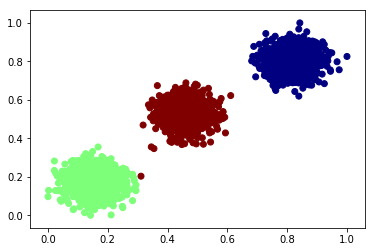

In [20]:
plt.scatter(x[:,0], x[:,1], c=y_hat, cmap='jet')

In [21]:
a = np.array([1,2,3,4,23,11,22,36,5,6,38,0])

In [24]:
ind = np.random.choice(np.arange(len(a)), len(a))

In [26]:
a[ind]

array([ 2,  4, 38,  0,  0,  1,  4, 11, 38, 23, 23,  4])

In [ ]:
tree = Tree(Gini, Mode) # classification

In [40]:
tree1 = Tree(np.var, np.mean) # regression

In [30]:
tree2 = copy(tree)

In [181]:
class BAgg:
    def __init__(self, root_tree, num_tree):
        self.root_tree = root_tree
        self.num_tree = num_tree
        self.trees = []
    def fit(self, x, y, sample_size = None):
        if sample_size is None:
            sample_size = len(x)
            
        for i in range(self.num_tree):
            ind = np.random.choice(np.arange(sample_size), sample_size)
            x_new = x[ind]
            y_new = y[ind]
            new_tree = copy(self.root_tree)
            new_tree.fit(x_new, y_new)
            self.trees.append(new_tree)
    
    def predict(self, x):
        y_hat = []
        for tree in self.trees:
            y_hat.append(tree.predict(x))
        y_hat = np.vstack(y_hat)
        return self.root_tree.agg_func(y_hat, axis=0)
        
    

In [182]:
bagg = BAgg(tree, 10)

In [183]:
bagg.fit(x,y)

TypeError: 'NoneType' object is not iterable

In [184]:
y_hat = bagg.predict(x)

ValueError: need at least one array to concatenate

In [92]:
y_hat.shape

(1, 1)

In [93]:
plt.scatter(x[:,0], x[:,1], c= y_hat[0,:], cmap='jet')

IndexError: index 1 is out of bounds for axis 1 with size 1

In [79]:
x = np.random.rand(1000,1) * 5 - 2.5
y = x ** 5 - 8* x ** 3 + 10 * x + 6 + np.random.randn(x.shape[0],1)

In [80]:
y = y.reshape(-1,)

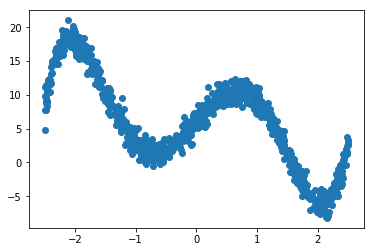

In [82]:
plt.scatter(x_reg,y_reg)

In [94]:
tree1 = Tree(np.var, np.mean)

In [95]:
bagg1 = BAgg(tree1, 10)

In [96]:
bagg1.fit(x,y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [97]:
y_hat = bagg1.predict(x)

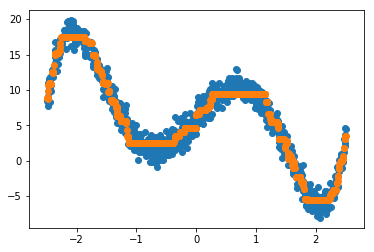

In [87]:
plt.scatter(x, y)
plt.scatter(x,y_hat)

In [219]:
class RandomForest:
    def __init__(self, root_tree, num_tree, feat_prop=1):
        self.root_tree = root_tree
        self.num_tree = num_tree
        self.feat_prop = feat_prop 
        
    def fit(self, x, y, sample_size = None):
        self.trees = []
        if sample_size is None:
            sample_size = len(x)    
        for i in range(self.num_tree):
            sample_ind = np.random.choice(np.arange(sample_size), sample_size, replace=True)
            feature_ind = np.random.choice(np.arange(x.shape[1]), round(self.feat_prop * x.shape[1] + 1e-99), replace=False)
            x_new = x[sample_ind, :]
            y_new = y[sample_ind]
            new_tree = copy(self.root_tree)
            new_tree.fit(x_new, y_new, feature_ind)
            self.trees.append(new_tree)
    
    def predict(self, x):
        y_hat = []
        for tree in self.trees:
            y_hat.append(tree.predict(x))
        y_hat = np.vstack(y_hat)
        return self.root_tree.agg_func(y_hat, axis=0)

In [220]:
forest = RandomForest(root_tree=tree, num_tree=10, feat_prop=0.5)

In [221]:
forest.fit(x,y)

In [222]:
y_hat = forest.predict(x)

In [223]:
y_hat.shape

(1, 3000)

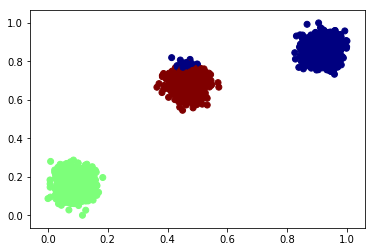

In [224]:
plt.scatter(x[:,0], x[:,1], c=y_hat.flatten(), cmap='jet')